In [20]:
import random
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from numba import njit
from rewards import Rewards

Rs = Rewards

In [21]:
from pandas import DataFrame, concat
from tqdm import tqdm

In [22]:
# from Sam Zorowitz code

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

@njit
def softmax(arr):
    """Scale-robust softmax function"""
    arr = np.exp(arr - np.max(arr))
    return arr / arr.sum()

@njit
def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal.'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

This is a draft of the EA-FD model from Toyama (2017)

In [23]:
# EA-FD model written as described by Toyama
class EA_draft(object):
    
    def __init__(self, b1, b2, a1, a2, af1, af2, w, lam, p, u, t):
        
        ## Define parameters.
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        self.af1 = af1
        self.af2 = af2
        self.w = w
        self.l = lam
        self.p = p
        self.u = u
        self.t = t

        ## Initialize Q-values.
        self.MB = None
        self.MF = None
        self.HYB = None
        
    def train(self, R, T=[[0.7,0.3],[0.3,0.7]], reset=False):
        
        ## Error-catching: rewards.
        R = np.array(R)
        
        ## Error-catching: transition probabilities.
        T = np.array(T)
        
        ## Initialize Q-values.
        if self.MB is None or reset:
            self.MB = 0.5 * np.ones(2)
        
        if self.MF is None or reset:
            self.MF = 0.5 * np.ones((3,2))
        
        if self.HYB is None or reset:
            self.HYB = 0.5 * np.ones(2)
            
        ## Preallocate space.
        n_trials = R.shape[0]
        Y = np.zeros((n_trials, 2), dtype=int)
        t = np.zeros(n_trials, dtype=int)
        r = np.zeros(n_trials)
        
        # C[0] = left, C[1] = right
        # choice traces
        C = np.zeros(2)
            
        for i in range(n_trials):
             
            # compute first stage model-based values based on transition
            # eq. 5 calcs
            self.MB[0] = 0.7*max(self.MF[1]) + 0.3*max(self.MF[2])
            self.MB[1] = 0.3*max(self.MF[1]) + 0.7*max(self.MF[2])
            
            # eq. 6 updates
            self.HYB[0] = self.w * self.MB[0] + (1 - self.w) * self.MF[0,0]
            self.HYB[1] = self.w * self.MB[1] + (1 - self.w) * self.MF[0,1]
            
            hybrid1 = self.HYB[1] - self.HYB[0]
            
            ## Stage 1: Compute choice likelihood.
            if i==0:
                theta = inv_logit( self.b1 * hybrid1 )
            else:
                # CHOICE TRACE QUESTION
                    # How should I include choice trace here? Instead of m?
                    # I added its updating lower down, but I'm not sure how to add it correctly here.
                m = -1 if Y[i-1,0] == 0 else 1
                theta = inv_logit( self.b1 * hybrid1 + self.p*m )

            ## 1 (0) => pi = -1
            ## 2 (1) => pi = 1
            
            ## Stage 1: Simulate choice.
            Y[i,0] = np.random.binomial(1,theta)
            
            ## Update choice trace
            C[Y[i,0]] = (1 - self.t) * C[Y[i,0]] + self.t
            C[1 - Y[i,0]] = (1 - self.t) * C[1 - Y[i,0]]
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S = np.where(t[i], Y[i,0], 1-Y[i,0]) + 1
            
            hybrid2 = self.MF[S,1] - self.MF[S,0]
                        
            ## Stage 2: Compute choice likelihood.
            theta = inv_logit( self.b2 * hybrid2 )
            
            ## Stage 2: Simulate choice.
            Y[i,1] = np.random.binomial(1,theta)
            
            ## Stage 2: Observe outcome.
            r[i] = R[i,S-1,Y[i,1]]
            
            # first and second stage Q-MF updates
            ## Chosen updates
            # FIRST STAGE UPDATED
            # eq. 2
            self.MF[0, Y[i,0]] += self.a1 * ( self.MF[S,Y[i,1]] - self.MF[0, Y[i,0]] )
            
            # SECOND STAGE UPDATED
            # eq. 3
            self.MF[S,Y[i,1]] += self.a2 * ( r[i] - self.MF[S, Y[i,1]] )
            
            ## Unchosen updates — eq. 12
            # Stage 1 unchosen
            self.MF[0, 1 - Y[i,0]] += self.af1 * (self.u - self.MF[0, 1 - Y[i,0]])
            # Stage 2 unchosen
            self.MF[S, 1 - Y[i,1]] += self.af2 * (self.u - self.MF[S, 1 - Y[i,1]])
            

            # TRANSITION QUESTION
            # see below where I hard-coded in 0.7 and 0.3
            
            # update chosen action -- eq. 9
            self.MF[0, Y[i,0]] = self.w * ( self.MF[0, Y[i,0]] + self.l * 0.7 * (r[i] - self.MF[0, Y[i,0]]) ) \
            + (1 - self.w) * (self.MF[0, Y[i,0]] + self.l * (r[i] - self.MF[0, Y[i,0]]))      
            # set index for unchosen action
            un_act = 1 - Y[i,0]
            # update unchosen action -- eq. 10
            self.MF[0, un_act] = self.w * ( self.MF[0, un_act] + self.l * 0.3 * (r[i] - self.MF[0, un_act]) ) \
            + (1 - self.w) * (self.MF[0, un_act] + self.l * (r[i] - self.MF[0, un_act]))  
            
            # equation #8 (Toyama 2017)
            #self.MF[0, Y[i,0]] += self.l * (r[i] - self.MF[0, Y[i,0]])

            
        return Y, t, r

100%|██████████| 200/200 [00:02<00:00, 91.16it/s]


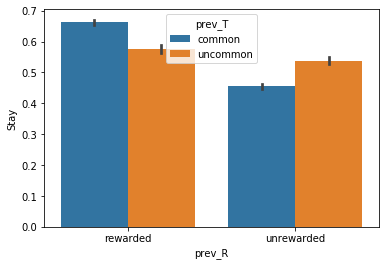

In [24]:
np.random.seed(11408)

data = []
for _ in tqdm(range(200)):
    
    ## Simulate outcomes.
    R = np.random.binomial(1, [[0.5,0.5],[0.5,0.5]], (200,2,2))
    
    ## Initialize agent.
    agent = EA_draft(b1 = 5, b2 = 5, a1 = 0.5, a2 = 0.5, af1=0.2, af2=0.2, w = 0.5, lam = 1, p = 0.2, u=0.5, t=0.2)

    ## Train agent.
    Y, t, r = agent.train(R)
    
    ## Define variables.
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = Y[:-1,0] == Y[1:,0]

    ## Blah.
    df = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

I'm very confused on how to make this work without MB Q-values, which the EA model seems to imply?